### Домашнее задание к вебинару 7 (fruit images for object detection)

In [1]:
import numpy as np
import os
import shutil
from pathlib import Path
from glob import glob #находит все пути по шаблону
from PIL import Image

import matplotlib.pyplot as plt
import cv2

import xml.etree.cElementTree as ET

Загрузим данные

In [2]:
train_path = '../input/fruit-images-for-object-detection/train_zip/train'

annotations_paths = sorted([i for i in Path(train_path).glob('*.xml')])
images_paths = sorted([i for i in Path(train_path).glob('*.jpg')])

test_path = '../input/fruit-images-for-object-detection/test_zip/test'

annots_test_paths = sorted([i for i in Path(test_path).glob('*.xml')])
images_test_paths = sorted([i for i in Path(test_path).glob('*.jpg')])

In [3]:
annots_test_paths[:3]

[PosixPath('../input/fruit-images-for-object-detection/test_zip/test/apple_77.xml'),
 PosixPath('../input/fruit-images-for-object-detection/test_zip/test/apple_78.xml'),
 PosixPath('../input/fruit-images-for-object-detection/test_zip/test/apple_79.xml')]

In [4]:
annotations_paths[:3]

[PosixPath('../input/fruit-images-for-object-detection/train_zip/train/apple_1.xml'),
 PosixPath('../input/fruit-images-for-object-detection/train_zip/train/apple_10.xml'),
 PosixPath('../input/fruit-images-for-object-detection/train_zip/train/apple_11.xml')]

In [5]:
img_path = '../input/fruit-images-for-object-detection/test_zip/test/mixed_21.jpg'
annot_path =  '../input/fruit-images-for-object-detection/test_zip/test/mixed_21.xml'

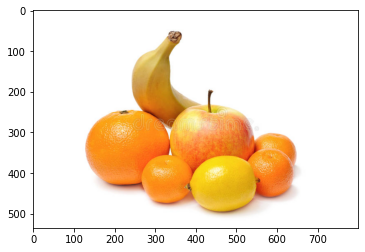

In [6]:
# Выведем выборочное изображение
img = np.array(Image.open(img_path))
plt.imshow(img)
plt.show()

In [7]:
with open(annot_path, 'r') as f:
    print(f.read())

<annotation>
	<folder>test</folder>
	<filename>mixed_21.jpg</filename>
	<path>C:\tensorflow1\models\research\object_detection\images\test\mixed_21.jpg</path>
	<source>
		<database>Unknown</database>
	</source>
	<size>
		<width>800</width>
		<height>535</height>
		<depth>3</depth>
	</size>
	<segmented>0</segmented>
	<object>
		<name>orange</name>
		<pose>Unspecified</pose>
		<truncated>0</truncated>
		<difficult>0</difficult>
		<bndbox>
			<xmin>133</xmin>
			<ymin>246</ymin>
			<xmax>337</xmax>
			<ymax>434</ymax>
		</bndbox>
	</object>
	<object>
		<name>orange</name>
		<pose>Unspecified</pose>
		<truncated>0</truncated>
		<difficult>0</difficult>
		<bndbox>
			<xmin>270</xmin>
			<ymin>364</ymin>
			<xmax>400</xmax>
			<ymax>476</ymax>
		</bndbox>
	</object>
	<object>
		<name>orange</name>
		<pose>Unspecified</pose>
		<truncated>0</truncated>
		<difficult>0</difficult>
		<bndbox>
			<xmin>522</xmin>
			<ymin>344</ymin>
			<xmax>649</xmax>
			<ymax>470</ymax>
		</bndbox>
	</object>
	<o

In [8]:
file = open(annot_path, 'r')
string = file.read()
tree = ET.fromstring(string)
xmin = []
ymin = []
xmax = []
ymax = []

for i in tree.iter("bndbox"):
    xmin.append(i.find('xmin').text)
    ymin.append(i.find('ymin').text)
    xmax.append(i.find('xmax').text)
    ymax.append(i.find('ymax').text)
    
coords = []
for i in range(len(xmin)):
    coords.extend(((int(xmin[i]), (int(ymin[i]))), (int(xmax[i]), int(ymax[i]))))

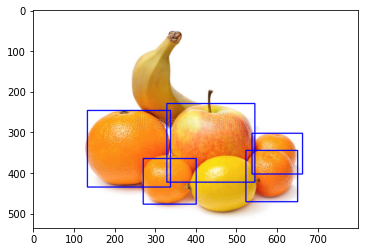

In [9]:
for i in range(0, len(coords), 2):
    start = (coords[i])
    end = (coords[i+1])
    cv2.rectangle(img, start, end, color = (0, 0, 255), thickness = 2) 
plt.imshow(img)
plt.show()

In [10]:
# img = np.array(Image.open(img_path))
# file = open(annot_path, 'r')
# string = file.read()
# coords = []
# coords.append(int(string[string.find('<xmin>') + len('<xmin>') : string.find('</xmin>')]))
# coords.append(int(string[string.find('<ymin>') + len('<ymin>') : string.find('</ymin>')]))
# coords.append(int(string[string.find('<xmax>') + len('<xmax>') : string.find('</xmax>')]))
# coords.append(int(string[string.find('<ymax>') + len('<ymax>') : string.find('</ymax>')]))
# file.close()

# cv2.rectangle(img, (coords[0], coords[1]), (coords[2], coords[3]), color = (0, 255, 0)) 
# plt.imshow(img)
# plt.show()

В этой аннотации есть проблема - ширина и высота = 0, что приведет к ошибке при обучении модели. Возможно, таких аннотаций несколько. Это нужно будет учесть и исправить.

In [11]:
# У нас есть 3 класса - яблоко, банан, апельсин
classes = np.array(["apple", "banana", "orange"])

### Preparing custom dataset

In [12]:
os.makedirs('imageai/data/train/images', exist_ok=True)
os.makedirs('imageai/data/train/annotations', exist_ok=True)

os.makedirs('imageai/data/validation/images', exist_ok=True)
os.makedirs('imageai/data/validation/annotations', exist_ok=True)

os.makedirs('imageai/data/test/images', exist_ok=True)
os.makedirs('imageai/data/test/annotations', exist_ok=True)

**Перед обучением модели, скорректируем нулевые значение ширины и высоты в аннотациях**

In [13]:
# Посчитаем сколько объектов с нулевыми значениями высоты и ширины
zero_wightheight_annotations_idx = []
zero_wightheight_annotations = []

for i, annotation in enumerate(annotations_paths):
    file = open(annotation, 'r')
    string = file.read()
    width = string[string.find('<width>')+len('<width>') : string.find('</width>')]
    height = string[string.find('<folder>')+len('<folder>') : string.find('</folder>')]
    
    if width == '0' or height == '0' :
        zero_wightheight_annotations_idx.append(i)
        zero_wightheight_annotations.append(annotation)
        
print(zero_wightheight_annotations_idx)
print(f'Всего {len(zero_wightheight_annotations)} объекта(ов) с нулевой шириной или высотой')

[0, 8, 12, 20, 29, 35, 36, 37, 73, 89, 100, 120, 124, 128, 140, 141, 144, 155, 168, 170, 172, 177, 182, 191, 196, 200, 203, 211, 212, 220, 226, 228, 231]
Всего 33 объекта(ов) с нулевой шириной или высотой


In [14]:
# При первоначальном обучении модели -появилась ошибка float division by zero, действительно в некоторых 
# встречаются нулевые значения ширины и высоты, исправим это

# ФУНКЦИЮ ПОДСМОТРЕЛА

def edit_annotation(file):
    
    my_file = open(file, 'r')
    string = my_file.read()
    
    width = string[string.find('<width>')+len('<width>') : string.find('</width>')]
    height = string[string.find('<height>')+len('<height>') : string.find('</height>')]
    
    if width == '0' or height == '0':
        
        folder = string[string.find('<folder>')+len('<folder>') : string.find('</folder>')]
        filename = string[string.find('<filename>')+len('<filename>') : string.find('</filename>')]
        path_img = f'../input/fruit-images-for-object-detection/{folder}_zip/{folder}/{filename}'
        
        im = Image.open(path_img)
        (width_im, height_im) = im.size

        tree = ET.parse(file)
        root = tree.getroot()

        for elem in root.iter("width"):
            elem.text = str(width_im)

        for elem in root.iter("height"):
            elem.text = str(height_im)

        tree.write('newfile.xml')

        return 'newfile.xml'
    
    else:
        return file

In [15]:
# разбиение и сохранение предобработанных данных

n_imgs = len(images_paths)
# n_split = n_imgs // 12

for i, (annot_path, img_path) in enumerate(zip(annotations_paths, images_paths)):   
    if i > n_imgs:
        break
        
    if i%5 == 0:
        # VALIDATION
        shutil.copy(img_path, 'imageai/data/validation/images/' + img_path.parts[-1])
        annot_path_edit = edit_annotation(annot_path)
        shutil.copy(annot_path_edit, 'imageai/data/validation/annotations/' + annot_path.parts[-1])
    else:
        #TRAIN
        shutil.copy(img_path, 'imageai/data/train/images/' + img_path.parts[-1])
        annot_path_edit = edit_annotation(annot_path)
        a = shutil.copy(annot_path_edit, 'imageai/data/train/annotations/' + annot_path.parts[-1])


for i, (annot_test_path, img_test_path) in enumerate(zip(annots_test_paths, images_test_paths)):  
    shutil.copy(img_test_path, 'imageai/data/test/images/' + img_test_path.parts[-1])
    annot_test_path_new = edit_annotation(annot_test_path)
    shutil.copy(annot_test_path_new, 'imageai/data/test/annotations/' + annot_test_path.parts[-1])

In [16]:
print(len(list(Path('imageai/data/train/annotations/').glob('*.xml'))))
print(len(list(Path('imageai/data/validation/annotations/').glob('*.xml'))))
print(len(list(Path('imageai/data/test/annotations/').glob('*.xml'))))

192
48
60


In [17]:
# Проверим, пропали ли все нулевые значения широты и высоты

zero_wightheight_annotations_idx = []
zero_wightheight_annotations = []

ap = glob(f"imageai/data/train/annotations/*.xml")
for i, path in enumerate(ap) :
    file = open(path, 'r')
    string = file.read()
    width = string[string.find('<width>')+len('<width>') : string.find('</width>')]
    height = string[string.find('<folder>')+len('<folder>') : string.find('</folder>')]
    
    if width == '0' or height == '0' :
        zero_wightheight_annotations_idx.append(i)
        zero_wightheight_annotations.append(annotation)
        
print(zero_wightheight_annotations_idx)
print(len(zero_wightheight_annotations))

[]
0


### Создаем и тренируем свою custom модель

##### ImageAI
https://github.com/OlafenwaMoses/ImageAI/blob/master/imageai/Detection/Custom/CUSTOMDETECTIONTRAINING.md

In [18]:
!pip install imageai 

     |████████████████████████████████| 160 kB 829 kB/s 
     |████████████████████████████████| 11.6 MB 5.8 MB/s 
     |████████████████████████████████| 14.9 MB 26.5 MB/s 
     |████████████████████████████████| 2.1 MB 56.0 MB/s 
     |████████████████████████████████| 26.1 MB 45.7 MB/s 
  Created wheel for keras-resnet: filename=keras_resnet-0.2.0-py2.py3-none-any.whl size=20486 sha256=cb3f54f671536dc87a1b0bd389ebd7f9f2874b408c59a4ccb958e8f8da18c86b
  Stored in directory: /root/.cache/pip/wheels/bd/ef/06/5d65f696360436c3a423020c4b7fd8c558c09ef264a0e6c575
Successfully built keras-resnet
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
  Attempting uninstall: scipy
    Found existing installation: scipy 1.5.4
    Uninstalling scipy-1.5.4:
      Successfully uninstalled scipy-1.5.4
  Attempting uninstall: pillow
    Found existing installation: Pillow 7.2.0
    Uninstalling Pillow-7.2.

In [19]:
from imageai.Detection.Custom import DetectionModelTrainer

trainer = DetectionModelTrainer()
trainer.setModelTypeAsYOLOv3()
trainer.setDataDirectory(data_directory="./imageai/data")
trainer.setTrainConfig(object_names_array=classes,
                       batch_size=10,
                       num_experiments=20,
                       train_from_pretrained_model="../input/gb-pretrainedyolov3h5/pretrained-yolov3.h5")

trainer.trainModel()

Generating anchor boxes for training images and annotation...
Average IOU for 9 anchors: 0.80
Anchor Boxes generated.
Detection configuration saved in  ./imageai/data/json/detection_config.json
Evaluating over 48 samples taken from ./imageai/data/validation
Training over 192 samples  given at ./imageai/data/train
Training on: 	['apple', 'banana', 'orange']
Training with Batch Size:  10
Number of Training Samples:  192
Number of Validation Samples:  48
Number of Experiments:  20
Training with transfer learning from pretrained Model


/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
/opt/conda/lib/python3.7/site-packages/tensorflow/python/data/ops/dataset_ops.py:3504: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


Epoch 1/20
160/160 [==============================] - 122s 724ms/step - loss: 145.0873 - yolo_layer_loss: 20.6116 - yolo_layer_1_loss: 34.2555 - yolo_layer_2_loss: 78.6421 - val_loss: 73.4028 - val_yolo_layer_loss: 12.3133 - val_yolo_layer_1_loss: 12.9276 - val_yolo_layer_2_loss: 36.5922
Epoch 2/20
160/160 [==============================] - 121s 751ms/step - loss: 56.1652 - yolo_layer_loss: 11.2471 - yolo_layer_1_loss: 13.0105 - yolo_layer_2_loss: 20.3561 - val_loss: 49.0653 - val_yolo_layer_loss: 10.9516 - val_yolo_layer_1_loss: 10.6688 - val_yolo_layer_2_loss: 15.9633
Epoch 3/20
160/160 [==============================] - 111s 689ms/step - loss: 48.4486 - yolo_layer_loss: 8.7563 - yolo_layer_1_loss: 12.6377 - yolo_layer_2_loss: 15.6102 - val_loss: 50.9879 - val_yolo_layer_loss: 11.3195 - val_yolo_layer_1_loss: 15.2588 - val_yolo_layer_2_loss: 13.1352
Epoch 4/20
160/160 [==============================] - 112s 694ms/step - loss: 45.8277 - yolo_layer_loss: 8.1077 - yolo_layer_1_loss: 11.

### Evaluate Model

In [20]:
custom_model_path = sorted(list(Path('./imageai/data/models/').iterdir()))[-1]

In [21]:
trainer.setModelTypeAsYOLOv3()
trainer.setDataDirectory(data_directory="./imageai/data/")
metrics = trainer.evaluateModel(model_path=custom_model_path,
                                json_path="imageai/data/json/detection_config.json",
                                
                                # подберем оптимальные трешхолды
                                iou_threshold=0.7, 
                                object_threshold=0.7,
                                nms_threshold=0.7) 

Starting Model evaluation....
Evaluating over 48 samples taken from ./imageai/data/validation
Training over 192 samples  given at ./imageai/data/train
Model File:  imageai/data/models/detection_model-ex-020--loss-0034.856.h5 

Evaluation samples:  48
Using IoU:  0.7
Using Object Threshold:  0.7
Using Non-Maximum Suppression:  0.7
apple: 0.0935
banana: 0.1551
orange: 0.0000
mAP: 0.0829


### Testing

In [22]:
from imageai.Detection.Custom import CustomObjectDetection

detector = CustomObjectDetection()
detector.setModelTypeAsYOLOv3()
detector.setModelPath(custom_model_path)
detector.setJsonPath("imageai/data/json/detection_config.json")
detector.loadModel()
detections = detector.detectObjectsFromImage(minimum_percentage_probability=45,
                                             input_image='imageai/data/test/images/mixed_21.jpg',
                                             output_image_path="detected.jpg")

In [23]:
for detection in detections:
    print(detection["name"], " : ", detection["percentage_probability"], " : ", detection["box_points"])

orange  :  47.59852588176727  :  [220, 72, 549, 405]
orange  :  48.00154268741608  :  [314, 198, 637, 520]
apple  :  75.05513429641724  :  [135, 236, 314, 450]
orange  :  72.12235927581787  :  [135, 236, 314, 450]


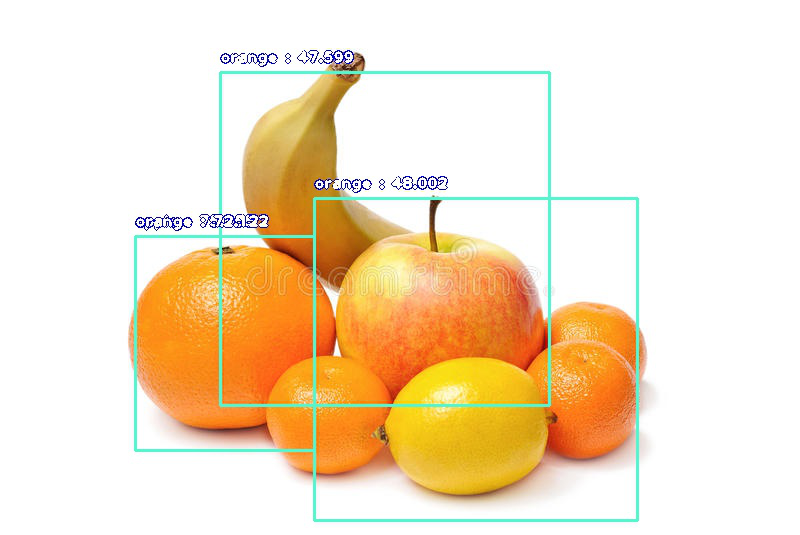

In [24]:
Image.open('detected.jpg')

In [25]:
from imageai.Detection.Custom import CustomObjectDetection

detector = CustomObjectDetection()
detector.setModelTypeAsYOLOv3()
detector.setModelPath(custom_model_path)
detector.setJsonPath("imageai/data/json/detection_config.json")
detector.loadModel()
detections = detector.detectObjectsFromImage(minimum_percentage_probability=80,
                                             input_image='imageai/data/test/images/banana_80.jpg',
                                             output_image_path="detected.jpg")

for detection in detections:
    print(detection["name"], " : ", detection["percentage_probability"], " : ", detection["box_points"])

banana  :  81.55449628829956  :  [65, 170, 361, 329]


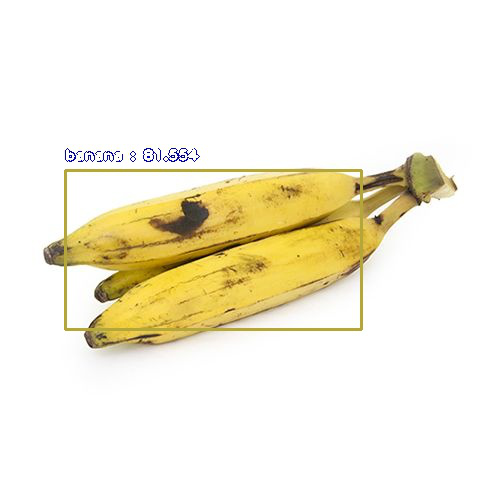

In [26]:
Image.open('detected.jpg')

В целом протестировав разые изображения, могу сказать, что модель плохо различает яблоки и апельсины, видимо из-за схожей формы. Однако бананы выделяет довольно однозначно